In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

In [2]:
class RWKV_Time_Mixing(torch.nn.Module):
    def __init__(self, embedding_dim, head_dim, num_heads, ctx_len):
        super().__init__()
        self.mu = nn.SiLU() 
        self.Receptance = nn.Linear(embedding_dim, num_heads * head_dim)
        self.Key = nn.Linear(embedding_dim, num_heads * head_dim)
        self.Value = nn.Linear(embedding_dim, num_heads * head_dim)
        self.output = nn.Linear(num_heads * head_dim, embedding_dim)
        
        self.num_heads = num_heads # Кол-во голов
        self.head_dim = head_dim # Размер головы
        self.ctx_len = ctx_len

        with torch.no_grad(): # initial time_w curves for better convergence
            ww = torch.ones(self.num_heads, self.ctx_len)
            curve = torch.tensor([-(self.ctx_len - 1 - i) for i in range(self.ctx_len)]) # the distance
            for h in range(self.num_heads):
                if h < self.num_heads - 1:
                    decay_speed = math.pow(self.ctx_len, -(h + 1)/(self.num_heads - 1))
                else:
                    decay_speed = 0.0
                ww[h] = torch.exp(curve * decay_speed)
        self.time_w = nn.Parameter(ww)
        self.time_alpha = nn.Parameter(torch.ones(self.num_heads, 1, self.ctx_len))
        self.time_beta = nn.Parameter(torch.ones(self.num_heads, self.ctx_len, 1))
        self.time_gamma = nn.Parameter(torch.ones(self.ctx_len, 1))
        self.time_shift = nn.ZeroPad2d((0, 0 , 1 , -1))

    def forward(self, x):
        B, T, C = x.size()

        TT = self.ctx_len
        w = F.pad(self.time_w, (0, TT))
        w = torch.tile(w, [TT])
        w = w[:, :-TT].reshape(-1, TT, 2 * TT - 1)
        w = w[:, :, TT-1:] # w is now a circulant matrix
        w = w[:, :T, :T] * self.time_alpha[:, :, :T] * self.time_beta[:, :T, :]

        x = torch.cat([self.time_shift(x[:, :, :C//2]), x[:, :, C//2:]], dim = -1)

        #--------

        x = self.mu(x) # (batch_size, seq_len, embedding_dim)
        r = torch.sigmoid(self.Receptance(x)) # (batch_size, seq_len, head_dim)
        k = self.Key(x) # (batch_size, seq_len, head_dim)
        v = self.Value(x) # (batch_size, seq_len, head_dim)


        k = torch.exp(k) # Возводим Key в экспоненту для сумм в Attm+(W, K, V) ()
        sum_k = torch.cumsum(k, dim = 1) # Кумулятивная сумма по , (batch_size, seq_len, head_dim)
        kv = (k * v).view(B, T, self.num_heads, self.head_dim) # матричное уможение
        wkv = (torch.einsum('htu,buhc->bthc', w, kv)).contiguous().view(B, T, -1)
        rwkv = wkv / sum_k # делим числитель на знаменатель
        rwkv = self.output(rwkv)

        return rwkv

In [3]:
class RWKV_Channel_Mixing(torch.nn.Module):
   def __init__(self, embedding_dim, hidden_dim):
      super().__init__()
      self.mu = nn.SiLU() 
      self.Receptance = nn.Linear(embedding_dim, embedding_dim)
      self.Key = nn.Linear(embedding_dim, hidden_dim)
      self.Value = nn.Linear(hidden_dim, embedding_dim)

   def forward(self, x):
      B, T, C = x.size()
      x = self.mu(x)
      r = torch.sigmoid(self.Receptance(x))
      kv = self.Value(self.Key(x))
      return (r * kv).view(B, T, -1)

In [4]:
class RWKV_Block(nn.Module):
    def __init__(self, embedding_dim, num_heads, head_dim, ctx_len, hidden_dim):
        super().__init__()

        self.Layer_Norm1 = nn.LayerNorm(embedding_dim)
        self.Layer_Norm2 = nn.LayerNorm(embedding_dim)

        self.timemix = RWKV_Time_Mixing(embedding_dim, head_dim, num_heads, ctx_len)
        self.channelmix = RWKV_Channel_Mixing(embedding_dim, hidden_dim)

    def forward(self, x):
        x = x + self.timemix(self.Layer_Norm1(x))
        x = x + self.channelmix(self.Layer_Norm2(x))
    
        return x

In [5]:
class RWKV_LM_Head(nn.Module):
    def __init__(self, embedding_dim, n_class):
        super().__init__()

        self.Layer_Norm = nn.LayerNorm(embedding_dim)
        self.output = nn.Linear(embedding_dim, n_class)

    def forward(self, x):
        x = self.output(self.Layer_Norm(x))
    
        return x

In [6]:
class RWKV_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, head_dim, ctx_len, hidden_dim, num_layers, n_class):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.Layer_Norm = nn.LayerNorm(embedding_dim)
        self.blocks = nn.Sequential(*[RWKV_Block(embedding_dim, num_heads, head_dim, ctx_len, hidden_dim) for i in range(num_layers)])
        self.lm_head = RWKV_LM_Head(embedding_dim, n_class)

    def forward(self, x):
        x = self.embedding(x)
        x = self.Layer_Norm(x)
        x = self.blocks(x)
        x = self.lm_head(x)
        return x
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Подготовка датасета

In [7]:
batch_size = 8
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 768 // 2
n_head = 12 # D = 384 // 6
n_layer = 12
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [9]:
import re

with open('/kaggle/input/nlp-rwkv-clean/dataset_with_dot_and_coma.txt', 'r') as file:
    lines = file.readlines()

new_lines = []
for line in lines:

    # убрать пробелы в начале строки, оставить только русские буквы, убрать строки, где только цифры (года написания стихов), названия стихов

    line = line.lstrip()
    line = re.sub(r'[^a-zA-Z\s\n.,]', '', line)
    if line.isdigit():
        continue
    line = line.replace("\u2005", "").replace("\u2009", "").replace("\u200a", "")
    line = line.replace("\u2002", " ").replace("\u2003", " ").replace("\u202f", " ").replace("\xa0", " ").replace("\u3000", " ").replace("\t", " ")
    
    new_lines.append(line)

with open('dataset_poetry_mac_modified.txt', 'w', encoding = 'MACCYRILLIC') as file:
    file.writelines(new_lines)

with open('dataset_poetry_mac_modified.txt', 'r', encoding = 'MACCYRILLIC') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [10]:
text[:600].split('\n')

['Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be unnecessary, undesirable, and harmful. As a historically leftwing movement, placed on the farthest left of the political spectrum, it is usually described alongside communalism and libertarian Marxism as the libertarian wing libertarian socialism of the socialist movement, and has a strong historical association with anticapitalism and socialism.',
 'Humans lived in societies without formal hie']

In [11]:
len(text)

213091159

In [12]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [13]:
loss_val = []

@torch.no_grad()
def estimate_loss():
    criterion = nn.CrossEntropyLoss()
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            Y = Y.view(B * T)
            loss = criterion(logits, Y)
            losses[k] = loss.item()
            loss_val.append(loss.item())
        out[split] = losses.mean()
    model.train()
    return out

# Модель

In [14]:
model = RWKV_model(vocab_size, n_embd, n_head, n_embd, block_size, n_embd, n_layer, vocab_size).to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

90.604088 M parameters


In [15]:
from tqdm import tqdm

## Обучение модели


In [16]:
loss_train = []

try:
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    for iter in tqdm(range(max_iters)):

        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch('train')
        logits = model(xb)
        B, T, C = logits.shape
        logits = logits.view(B * T, C)
        yb = yb.view(B * T)
        loss = criterion(logits, yb)
        loss_train.append(loss)
        optimizer.zero_grad(set_to_none = True)
        loss.backward()
        optimizer.step()

except KeyboardInterrupt: 0

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.2560, val loss 4.2588


 10%|█         | 501/5000 [03:01<12:47:01, 10.23s/it]

step 500: train loss 1.9201, val loss 1.9461


 20%|██        | 1001/5000 [05:29<11:21:48, 10.23s/it]

step 1000: train loss 1.6888, val loss 1.7009


 30%|███       | 1501/5000 [07:56<9:57:04, 10.24s/it] 

step 1500: train loss 1.5834, val loss 1.5951


 40%|████      | 2001/5000 [10:24<8:31:38, 10.24s/it]

step 2000: train loss 1.5216, val loss 1.5332


 50%|█████     | 2501/5000 [12:51<7:06:59, 10.25s/it]

step 2500: train loss 1.4858, val loss 1.4955


 60%|██████    | 3001/5000 [15:19<5:41:10, 10.24s/it]

step 3000: train loss 1.4578, val loss 1.4512


 70%|███████   | 3501/5000 [17:46<4:16:00, 10.25s/it]

step 3500: train loss 1.4192, val loss 1.4271


 80%|████████  | 4001/5000 [20:14<2:50:40, 10.25s/it]

step 4000: train loss 1.4096, val loss 1.4117


 90%|█████████ | 4501/5000 [22:42<1:25:14, 10.25s/it]

step 4500: train loss 1.3779, val loss 1.3866


100%|██████████| 5000/5000 [25:09<00:00,  3.31it/s]  

step 4999: train loss 1.3553, val loss 1.3790


In [40]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens = 500)[0].tolist()))


town in the Soviet Union, then venicians from the south, the Emperor A. The function of the National. They were allowed by threatmatus Tracts then, and the units in Leava at Berlit Damah Troes. Milant and name that tiles farinth, the desire advocation, and it is not have a largely batt a number of clembing.
The warsh roles that raised many times, Agaris was not provided in . After his rich name protay, but was shared by a gotting such at Caylin had to be known for Angohishi, showed, both for the


In [53]:
text = "Soviet Union"
context = torch.tensor([encode(text)], dtype=torch.long, device=device)

In [54]:
print(decode(model.generate(context, max_new_tokens = 500)[0].tolist()))

Soviet Union, which users Everbat fielding services, playing that the Jewish, and Dosing Language and Lorwican , Fiope The King OccoGnozari had been the physical bammar and Puercy football magic. The froption of the  work and various incorporation in . At a monthly a role told world, since the year, the government, and shopping a defect team trade. In three prototypes than you was hold at his life, the scats traditional Park , before had flow to Italy Best, the Rosar questions. When Borisa, Grance, the Base


In [18]:
loss_train = [el.cpu() for el in loss_train]

In [19]:
loss_train = [el.item() for el in loss_train]

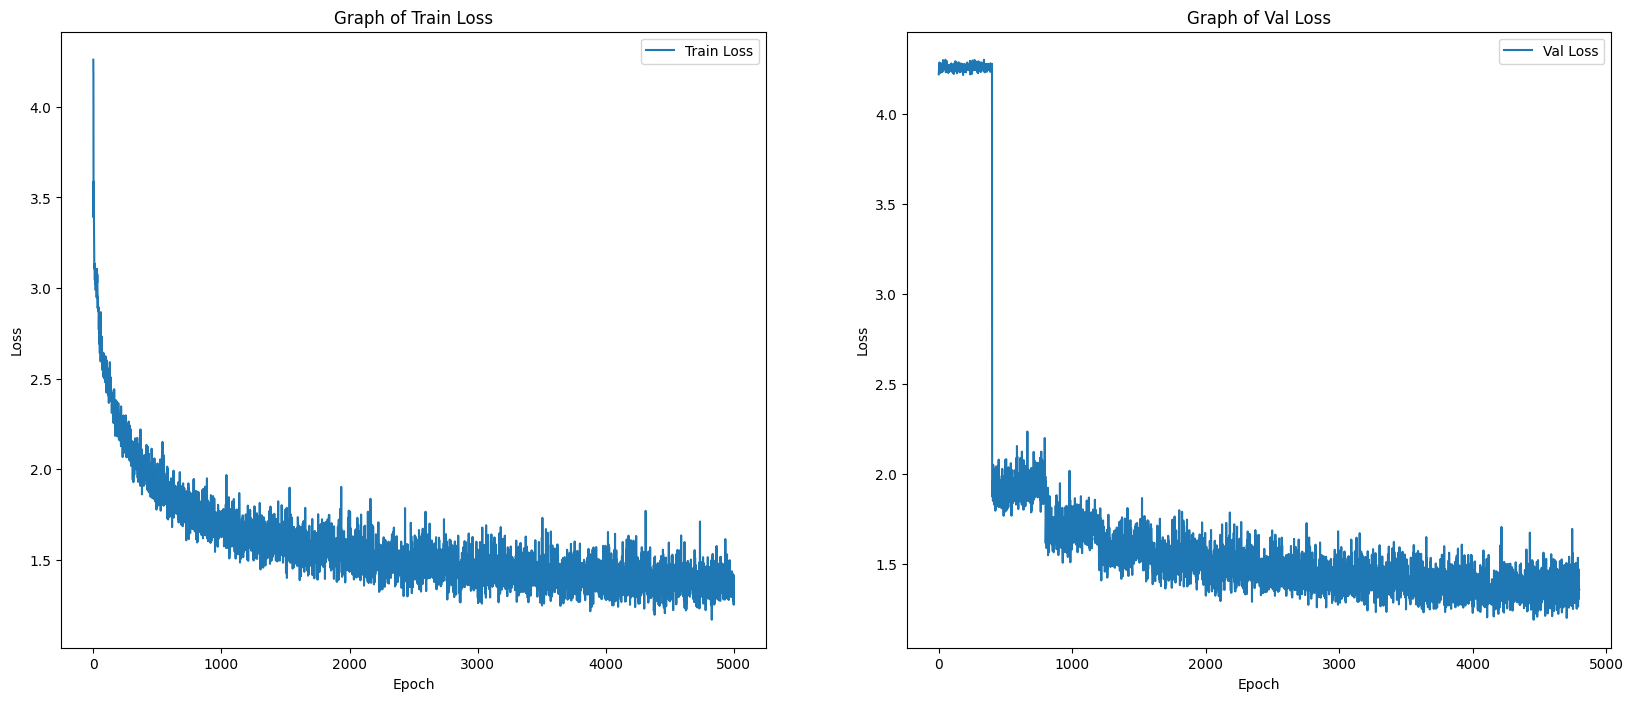

In [38]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax1.plot(loss_train, label='Train Loss')
ax1.set_title('Graph of Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(loss_val, label='Val Loss')
ax2.set_title('Graph of Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.subplots_adjust(hspace=0.5)

plt.show()


In [39]:
torch.save(model, 'rwkv-90m.pth')